## Import the Basic Packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import datetime as dt
%matplotlib inline
import math
import pandas_profiling
import sweetviz
from sklearn.model_selection import train_test_split
from sklearn import metrics

from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.linear_model import LogisticRegression

print(pd.__version__)
print(np.__version__)
print(sns.__version__)

0.25.3
1.16.5
0.9.0


## Create User Defined Functions

In [2]:
# Create Data audit Report for continuous variables
def continuous_var_summary(x):
    return pd.Series([
        x.count(),
        x.isnull().sum(),
        x.sum(),
        x.mean(),
        x.median(),
        x.std(),
        x.var(),
        x.min(),
        x.quantile(0.01),
        x.quantile(0.05),
        x.quantile(0.10),
        x.quantile(0.25),
        x.quantile(0.50),
        x.quantile(0.75),
        x.quantile(0.90),
        x.quantile(0.95),
        x.quantile(0.99),
        x.max()
    ],
                     index=[
                         'N', 'NMISS', 'SUM', 'MEAN', 'MEDIAN', 'STD', 'VAR',
                         'MIN', 'P1', 'P5', 'P10', 'P25', 'P50', 'P75', 'P90',
                         'P95', 'P99', 'MAX'
                     ])

In [3]:
# Create Data audit Report for categorical variables
def categorical_var_summary(x):
    Mode = x.value_counts().sort_values(ascending=False)[0:1].reset_index()
    return pd.Series([
        x.count(),
        x.isnull().sum(), Mode.iloc[0, 0], Mode.iloc[0, 1],
        round(Mode.iloc[0, 1] * 100 / x.count(), 2)
    ],
                     index=['N', 'NMISS', 'MODE', 'FREQ', 'PERCENT'])

In [4]:
# Missing value imputation for categorical and continuous variables
def missing_imputation(x, stats='mean'):
    if (x.dtypes == 'float64') | (x.dtypes == 'int64'):
        x = x.fillna(x.mean()) if stats == 'mean' else x.fillna(x.median())
    else:
        x = x.fillna(x.mode())
    return x 

In [5]:
#An utility function to create dummy variable
def create_dummies(df, colname):
    col_dummies = pd.get_dummies(df[colname], prefix=colname, drop_first=True)
    df = pd.concat([df, col_dummies], axis=1)
    df.drop(colname, axis=1, inplace=True)
    return df

In [6]:
# create user defined function to create the freq plots
def fn_countplot(pd_series):
    plt.figure(figsize=(5, 3))
    sns.countplot(y=pd_series)
    print('This is a freq chart for ' + pd_series.name)
    plt.show()
    return

### Importing the Datasets

In [7]:
train = pd.read_csv(
    'C:/Users/shaur/Downloads/6a62a5b4967411ea/Dataset/train.csv'
)  #Importing the train data

test = pd.read_csv('C:/Users/shaur/Downloads/6a62a5b4967411ea/Dataset/test.csv'
                   )  #Importing the test data

sample_submission = pd.read_csv(
    'C:/Users/shaur/Downloads/6a62a5b4967411ea/Dataset/sample_submission.csv'
)  #Importing the sample submission data

In [8]:
train.head()   #First 5 elements of the dataset

,INCIDENT_ID,DATE,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,X_9,X_10,X_11,X_12,X_13,X_14,X_15,MULTIPLE_OFFENSE
0,CR_102659,04-JUL-04,0,36,34,2,1,5,6,1,6,1,174,1.0,92,29,36,0
1,CR_189752,18-JUL-17,1,37,37,0,0,11,17,1,6,1,236,1.0,103,142,34,1
2,CR_184637,15-MAR-17,0,3,2,3,5,1,0,2,3,1,174,1.0,110,93,34,1
3,CR_139071,13-FEB-09,0,33,32,2,1,7,1,1,6,1,249,1.0,72,29,34,1
4,CR_109335,13-APR-05,0,33,32,2,1,8,3,0,5,1,174,0.0,112,29,43,1


In [13]:
train.info()  #Description of the data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23856 entries, 0 to 23855
Data columns (total 18 columns):
INCIDENT_ID         23856 non-null object
DATE                23856 non-null object
X_1                 23856 non-null int64
X_2                 23856 non-null int64
X_3                 23856 non-null int64
X_4                 23856 non-null int64
X_5                 23856 non-null int64
X_6                 23856 non-null int64
X_7                 23856 non-null int64
X_8                 23856 non-null int64
X_9                 23856 non-null int64
X_10                23856 non-null int64
X_11                23856 non-null int64
X_12                23674 non-null float64
X_13                23856 non-null int64
X_14                23856 non-null int64
X_15                23856 non-null int64
MULTIPLE_OFFENSE    23856 non-null int64
dtypes: float64(1), int64(15), object(2)
memory usage: 3.3+ MB


In [14]:
train.describe()  #Generate descriptive statistics.

,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,X_9,X_10,X_11,X_12,X_13,X_14,X_15,MULTIPLE_OFFENSE
count,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,23674.000000,23856.000000,23856.000000,23856.000000,23856.000000
mean,0.483778,24.791206,24.637450,4.276744,2.455609,6.154175,4.876509,0.972460,4.924128,1.244802,206.954519,0.974064,85.237383,72.674296,33.464747,0.955231
std,1.439738,15.240231,15.135093,2.944672,1.963095,4.471756,3.881931,1.453144,1.362625,1.119301,93.033348,1.167725,27.597226,43.297320,8.386834,0.206800
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,7.000000,8.000000,2.000000,1.000000,3.000000,2.000000,0.000000,5.000000,1.000000,174.000000,1.000000,72.000000,29.000000,34.000000,1.000000
50%,0.000000,24.000000,24.000000,4.000000,3.000000,5.000000,4.000000,1.000000,5.000000,1.000000,249.000000,1.000000,98.000000,62.000000,34.000000,1.000000
75%,0.000000,36.000000,35.000000,6.000000,5.000000,8.000000,7.000000,1.000000,6.000000,1.000000,249.000000,1.000000,103.000000,107.000000,34.000000,1.000000
max,7.000000,52.000000,52.000000,10.000000,5.000000,19.000000,18.000000,99.000000,6.000000,90.000000,332.000000,90.000000,116.000000,142.000000,50.000000,1.000000


In [15]:
test.head() #First 5 elements of the dataset

,INCIDENT_ID,DATE,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,X_9,X_10,X_11,X_12,X_13,X_14,X_15
0,CR_195453,01-FEB-18,0,30,35,7,3,6,4,0,5,1,174,NaN,72,119,23
1,CR_103520,05-MAR-04,0,44,44,1,3,7,1,4,6,1,316,0.0,12,29,34
2,CR_196089,27-JAN-18,0,34,33,3,5,2,7,3,0,1,316,1.0,72,0,34
3,CR_112195,18-AUG-06,7,3,2,3,5,9,8,0,5,1,174,1.0,112,87,34
4,CR_149832,31-OCT-11,0,7,8,7,3,2,7,1,5,1,174,0.0,112,93,43


In [16]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15903 entries, 0 to 15902
Data columns (total 17 columns):
INCIDENT_ID    15903 non-null object
DATE           15903 non-null object
X_1            15903 non-null int64
X_2            15903 non-null int64
X_3            15903 non-null int64
X_4            15903 non-null int64
X_5            15903 non-null int64
X_6            15903 non-null int64
X_7            15903 non-null int64
X_8            15903 non-null int64
X_9            15903 non-null int64
X_10           15903 non-null int64
X_11           15903 non-null int64
X_12           15776 non-null float64
X_13           15903 non-null int64
X_14           15903 non-null int64
X_15           15903 non-null int64
dtypes: float64(1), int64(14), object(2)
memory usage: 2.1+ MB


In [17]:
test.describe()

,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,X_9,X_10,X_11,X_12,X_13,X_14,X_15
count,15903.000000,15903.000000,15903.000000,15903.000000,15903.000000,15903.000000,15903.000000,15903.000000,15903.000000,15903.000000,15903.000000,15776.000000,15903.000000,15903.000000,15903.000000
mean,0.468088,24.722631,24.575049,4.284223,2.448469,6.084890,4.862605,0.986732,4.908759,1.241212,206.954097,0.972236,85.191096,72.218575,33.422625
std,1.412112,15.228841,15.127451,2.974584,1.963372,4.451117,3.854550,1.471274,1.374677,0.841804,93.107783,0.876669,27.493192,43.438227,8.314284
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,7.000000,8.000000,2.000000,1.000000,3.000000,2.000000,0.000000,5.000000,1.000000,174.000000,1.000000,72.000000,29.000000,34.000000
50%,0.000000,24.000000,24.000000,4.000000,3.000000,5.000000,4.000000,1.000000,5.000000,1.000000,249.000000,1.000000,98.000000,62.000000,34.000000
75%,0.000000,36.000000,35.000000,6.000000,5.000000,8.000000,7.000000,1.000000,6.000000,1.000000,249.000000,1.000000,103.000000,107.000000,34.000000
max,7.000000,52.000000,52.000000,10.000000,5.000000,19.000000,18.000000,50.000000,6.000000,40.000000,332.000000,40.000000,117.000000,142.000000,50.000000


In [18]:
#Separating the categorial and continous variables

train_cont = train.select_dtypes(['int64', 'float64'])
train_cat = train.select_dtypes(['object'])  #The categorical features are not important as they are cardinal.

test_cont = test.select_dtypes(['int64', 'float64'])
test_cat = test.select_dtypes(['object']) #The categorical features are not important as they are cardinal.

In [19]:
train_cont.apply(continuous_var_summary)   #Descriptive statistics with more features for continous features

,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,X_9,X_10,X_11,X_12,X_13,X_14,X_15,MULTIPLE_OFFENSE
N,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,2.385600e+04,23674.000000,2.385600e+04,2.385600e+04,23856.000000,23856.000000
NMISS,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,182.000000,0.000000e+00,0.000000e+00,0.000000,0.000000
SUM,11541.000000,591419.000000,587751.000000,102026.000000,58581.000000,146814.000000,116334.000000,23199.000000,117470.000000,29696.000000,4.937107e+06,23060.000000,2.033423e+06,1.733718e+06,798335.000000,22788.000000
MEAN,0.483778,24.791206,24.637450,4.276744,2.455609,6.154175,4.876509,0.972460,4.924128,1.244802,2.069545e+02,0.974064,8.523738e+01,7.267430e+01,33.464747,0.955231
MEDIAN,0.000000,24.000000,24.000000,4.000000,3.000000,5.000000,4.000000,1.000000,5.000000,1.000000,2.490000e+02,1.000000,9.800000e+01,6.200000e+01,34.000000,1.000000
STD,1.439738,15.240231,15.135093,2.944672,1.963095,4.471756,3.881931,1.453144,1.362625,1.119301,9.303335e+01,1.167725,2.759723e+01,4.329732e+01,8.386834,0.206800
VAR,2.072845,232.264640,229.071025,8.671094,3.853741,19.996602,15.069386,2.111629,1.856746,1.252834,8.655204e+03,1.363582,7.616069e+02,1.874658e+03,70.338979,0.042766
MIN,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000
P1,0.000000,3.000000,2.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000e+00,0.000000,1.000000e+01,0.000000e+00,0.000000,0.000000
P5,0.000000,4.000000,4.000000,0.000000,0.000000,1.000000,0.000000,0.000000,2.000000,1.000000,0.000000e+00,0.000000,1.800000e+01,2.900000e+01,23.000000,1.000000


In [20]:
train_cat.apply(categorical_var_summary)  #Descriptive statistics with more features for categorical features

,INCIDENT_ID,DATE
N,23856,23856
NMISS,0,0
MODE,CR_31819,12-SEP-01
FREQ,1,22
PERCENT,0,0.09


In [21]:
test_cont.apply(continuous_var_summary)   #Descriptive statistics with more features for continous features

,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,X_9,X_10,X_11,X_12,X_13,X_14,X_15
N,15903.000000,15903.000000,15903.000000,15903.000000,15903.000000,15903.000000,15903.000000,15903.000000,15903.000000,15903.000000,1.590300e+04,15776.000000,1.590300e+04,1.590300e+04,15903.000000
NMISS,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,127.000000,0.000000e+00,0.000000e+00,0.000000
SUM,7444.000000,393164.000000,390817.000000,68132.000000,38938.000000,96768.000000,77330.000000,15692.000000,78064.000000,19739.000000,3.291191e+06,15338.000000,1.354794e+06,1.148492e+06,531520.000000
MEAN,0.468088,24.722631,24.575049,4.284223,2.448469,6.084890,4.862605,0.986732,4.908759,1.241212,2.069541e+02,0.972236,8.519110e+01,7.221858e+01,33.422625
MEDIAN,0.000000,24.000000,24.000000,4.000000,3.000000,5.000000,4.000000,1.000000,5.000000,1.000000,2.490000e+02,1.000000,9.800000e+01,6.200000e+01,34.000000
STD,1.412112,15.228841,15.127451,2.974584,1.963372,4.451117,3.854550,1.471274,1.374677,0.841804,9.310778e+01,0.876669,2.749319e+01,4.343823e+01,8.314284
VAR,1.994061,231.917591,228.839780,8.848152,3.854831,19.812439,14.857552,2.164646,1.889738,0.708635,8.669059e+03,0.768548,7.558756e+02,1.886880e+03,69.127314
MIN,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000
P1,0.000000,3.000000,2.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000e+00,0.000000,2.000000e+00,0.000000e+00,0.000000
P5,0.000000,4.000000,4.000000,0.000000,0.000000,1.000000,0.000000,0.000000,2.000000,1.000000,0.000000e+00,0.000000,1.800000e+01,2.500000e+01,23.000000


In [22]:
test_cat.apply(categorical_var_summary)  #Descriptive statistics with more features for categorical features

,INCIDENT_ID,DATE
N,15903,15903
NMISS,0,0
MODE,CR_67267,13-SEP-01
FREQ,1,16
PERCENT,0.01,0.1


#### Null value treatment. There are some features which have limited null values. We will treat them with mean/median and mode for continous and categorical features respectively. (Categorical values dont have null values)

In [23]:
train_cont = train_cont.apply(missing_imputation)

In [24]:
test_cont = test_cont.apply(missing_imputation)

#### With the descriptive summary, we see that we have outlier data. We treat outlier data depending on the domain. We will remove outliers in this dataset.

In [25]:
'''
We found that we had outlier data in the summary so handling outliers. We will treat that by clipping values over 99 percentile.
'''
def outlier_capping(x):
    x = x.clip(upper=x.quantile(0.99))
    x = x.clip(lower=x.quantile(0.01))
    return x


train_cont = train_cont.apply(outlier_capping)
test_cont = test_cont.apply(outlier_capping)

## Exploratory Data Analysis

In [26]:
#report = pandas_profiling.ProfileReport(train)
#
#report.to_file(
#    'C:/Users/shaur/Downloads/6a62a5b4967411ea/Dataset/profilereporttrain.html'
#)
#
#report

In [27]:
#report1 = pandas_profiling.ProfileReport(test)
#
#report1.to_file(
#    'C:/Users/shaur/Downloads/6a62a5b4967411ea/Dataset/profilereporttest.html')
#
#report1

In [28]:
#import sweetviz as sv
#
#my_report = sv.analyze(train)
#my_report.show_html()

In [29]:
#my_report1 = sv.analyze(test)
#my_report1.show_html()

In [30]:
#my_report2 = sv.compare([train, "Training Data"], [test, "Test Data"],
#                        "MULTIPLE_OFFENSE")
#my_report2.show_html()

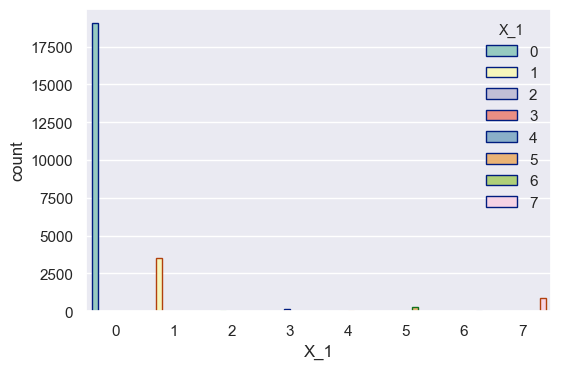

In [793]:
# Logging parameters distribution
plt.figure(figsize=(6, 4))
plt.style.use('ggplot')
sns.set(style="darkgrid")
sns.countplot(x="X_1",
              data=train_cont,
              palette="Set3",
              hue='X_1',
              edgecolor=sns.color_palette("dark", 3))
plt.show()

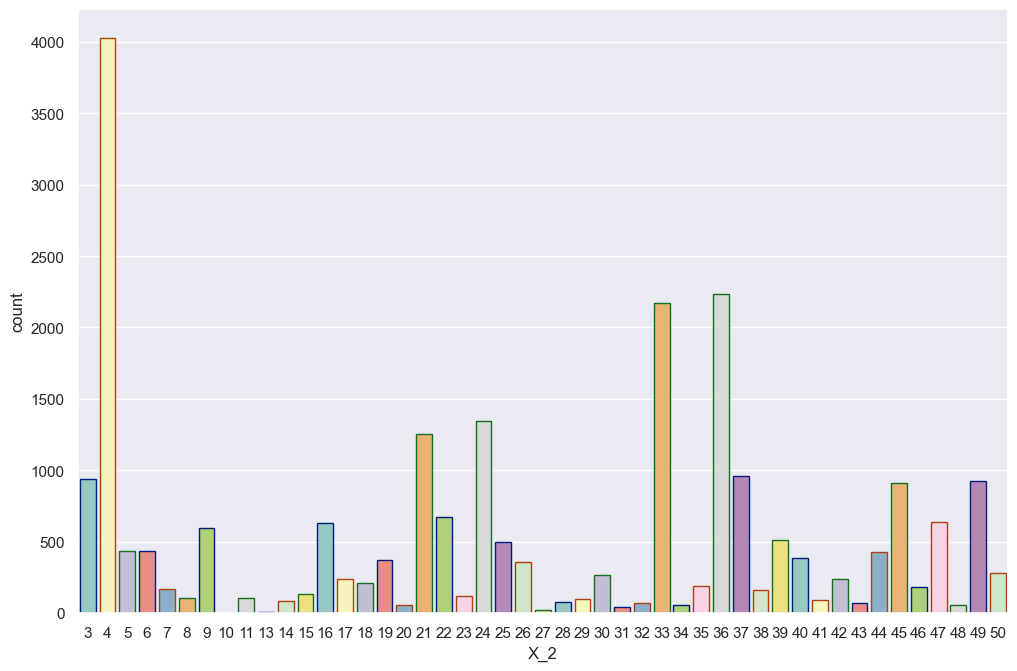

In [794]:
# Logging parameters distribution
plt.figure(figsize=(12, 8))
plt.style.use('ggplot')
sns.set(style="darkgrid")
sns.countplot(x="X_2",
              data=train_cont,
              palette="Set3",
              edgecolor=sns.color_palette("dark", 3))
plt.show()

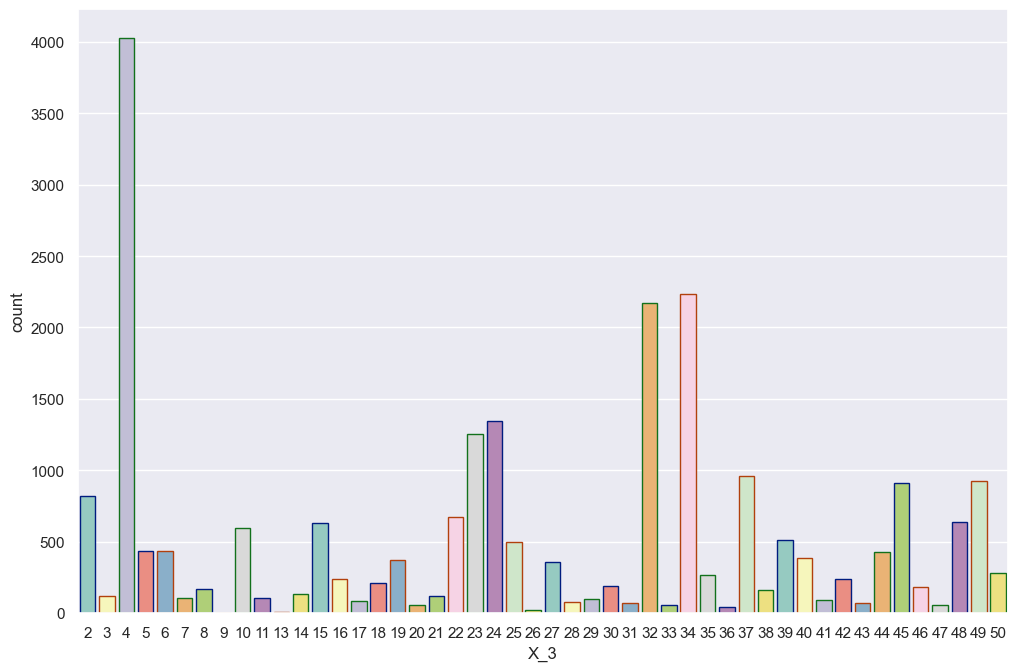

In [795]:
# Logging parameters distribution
plt.figure(figsize=(12, 8))
plt.style.use('ggplot')
sns.set(style="darkgrid")
sns.countplot(x="X_3",
              data=train_cont,
              palette="Set3",
              edgecolor=sns.color_palette("dark", 3))
plt.show()

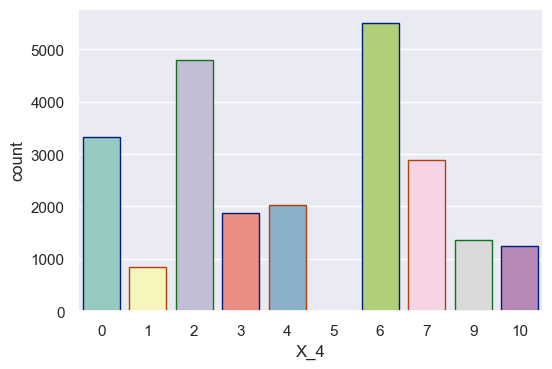

In [796]:
# Logging parameters distribution
plt.figure(figsize=(6, 4))
plt.style.use('ggplot')
sns.set(style="darkgrid")
sns.countplot(x="X_4",
              data=train_cont,
              palette="Set3",
              edgecolor=sns.color_palette("dark", 3))
plt.show()

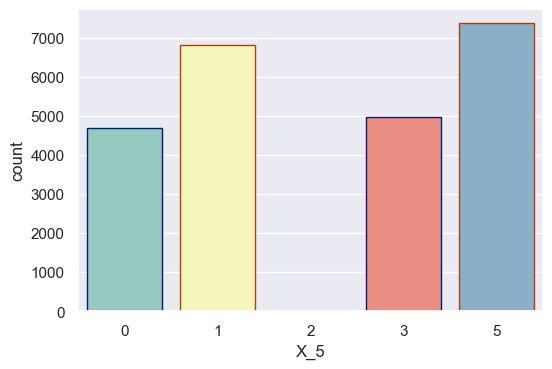

In [797]:
# Logging parameters distribution
plt.figure(figsize=(6, 4))
plt.style.use('ggplot')
sns.set(style="darkgrid")
sns.countplot(x="X_5",
              data=train_cont,
              palette="Set3",
              edgecolor=sns.color_palette("dark", 3))
plt.show()

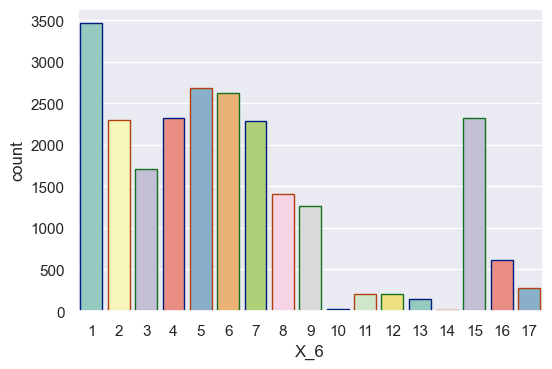

In [798]:
# Logging parameters distribution
plt.figure(figsize=(6, 4))
plt.style.use('ggplot')
sns.set(style="darkgrid")
sns.countplot(x="X_6",
              data=train_cont,
              palette="Set3",
              edgecolor=sns.color_palette("dark", 3))
plt.show()

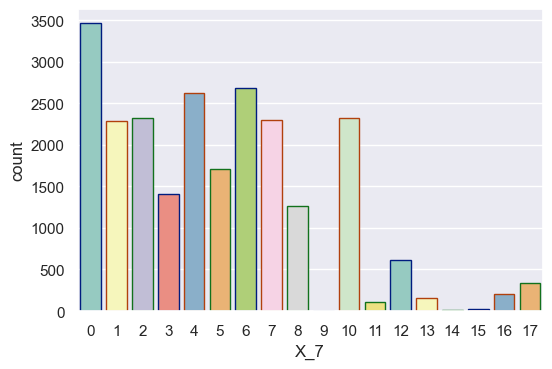

In [799]:
# Logging parameters distribution
plt.figure(figsize=(6, 4))
plt.style.use('ggplot')
sns.set(style="darkgrid")
sns.countplot(x="X_7",
              data=train_cont,
              palette="Set3",
              edgecolor=sns.color_palette("dark", 3))
plt.show()

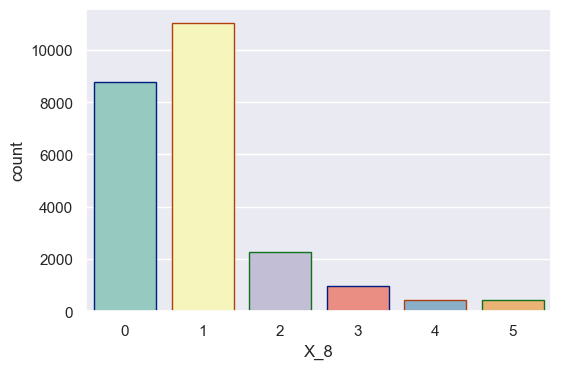

In [800]:
# Logging parameters distribution
plt.figure(figsize=(6, 4))
plt.style.use('ggplot')
sns.set(style="darkgrid")
sns.countplot(x="X_8",
              data=train_cont,
              palette="Set3",
              edgecolor=sns.color_palette("dark", 3))
plt.show()

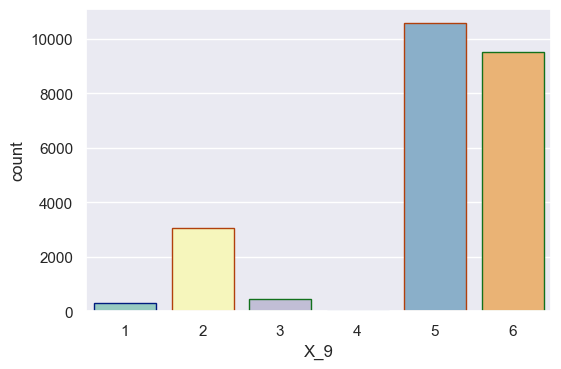

In [801]:
# Logging parameters distribution
plt.figure(figsize=(6, 4))
plt.style.use('ggplot')
sns.set(style="darkgrid")
sns.countplot(x="X_9",
              data=train_cont,
              palette="Set3",
              edgecolor=sns.color_palette("dark", 3))
plt.show()

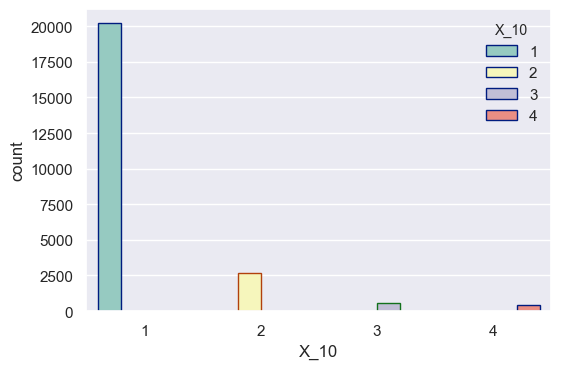

In [802]:
# Logging parameters distribution
plt.figure(figsize=(6, 4))
plt.style.use('ggplot')
sns.set(style="darkgrid")
sns.countplot(x="X_10",
              data=train_cont,
              palette="Set3",
               hue = 'X_10',
              edgecolor=sns.color_palette("dark", 3))
plt.show()

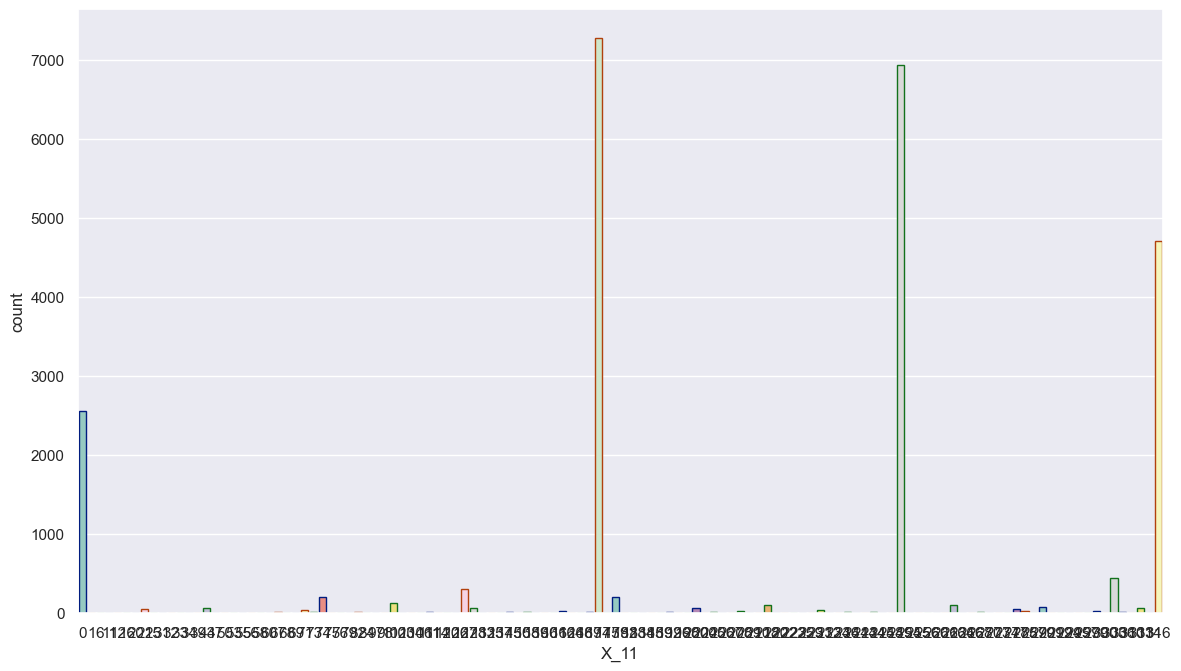

In [803]:
# Logging parameters distribution
plt.figure(figsize=(14, 8))
plt.style.use('ggplot')
sns.set(style="darkgrid")
sns.countplot(x="X_11",
              data=train_cont,
              palette="Set3",
              edgecolor=sns.color_palette("dark", 3))
plt.show()

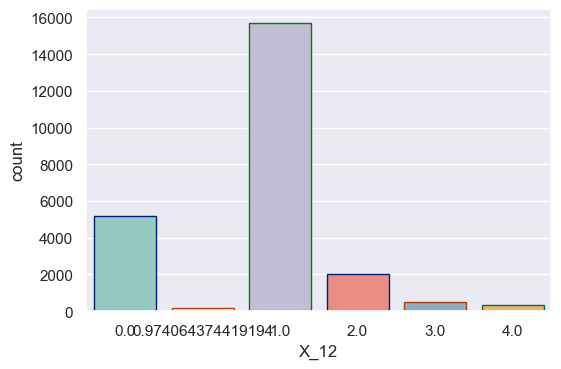

In [804]:
# Logging parameters distribution
plt.figure(figsize=(6, 4))
plt.style.use('ggplot')
sns.set(style="darkgrid")
sns.countplot(x="X_12",
              data=train_cont,
              palette="Set3",
              edgecolor=sns.color_palette("dark", 3))
plt.show()

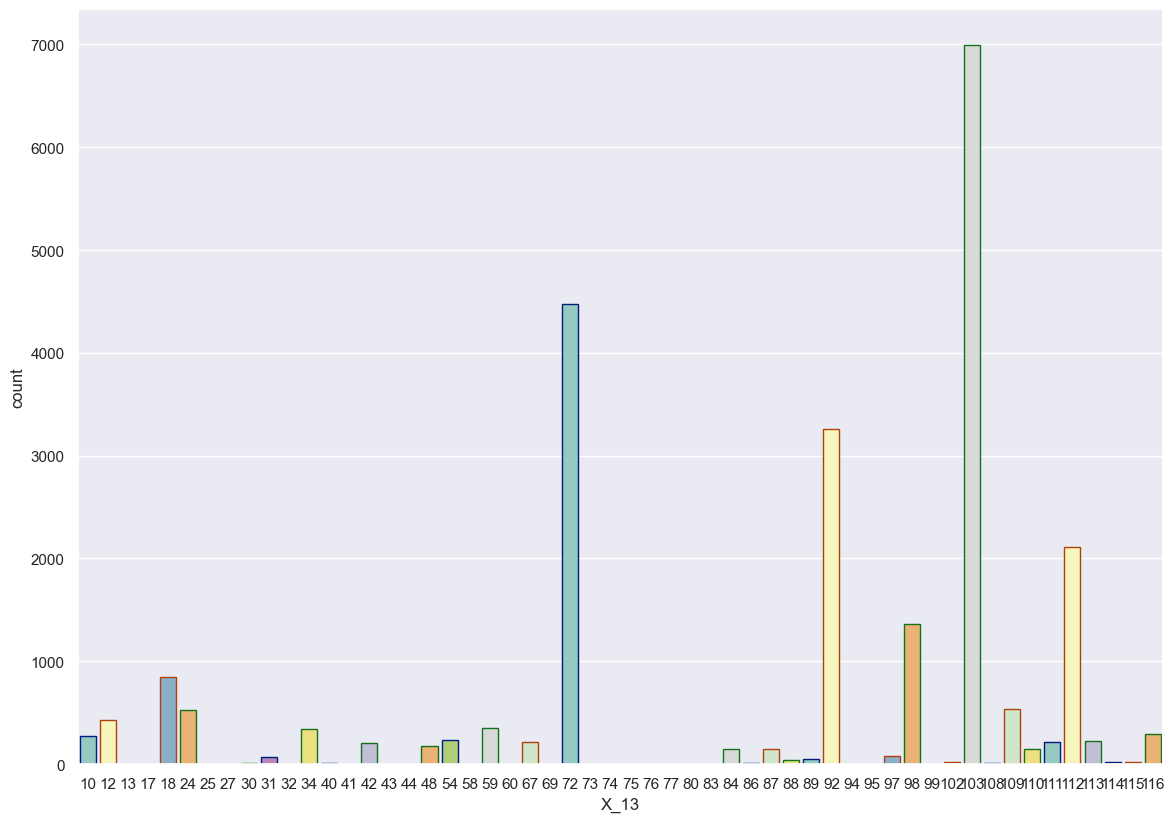

In [805]:
# Logging parameters distribution
plt.figure(figsize=(14, 10))
plt.style.use('ggplot')
sns.set(style="darkgrid")
sns.countplot(x="X_13",
              data=train_cont,
              palette="Set3",
              edgecolor=sns.color_palette("dark", 3))
plt.show()

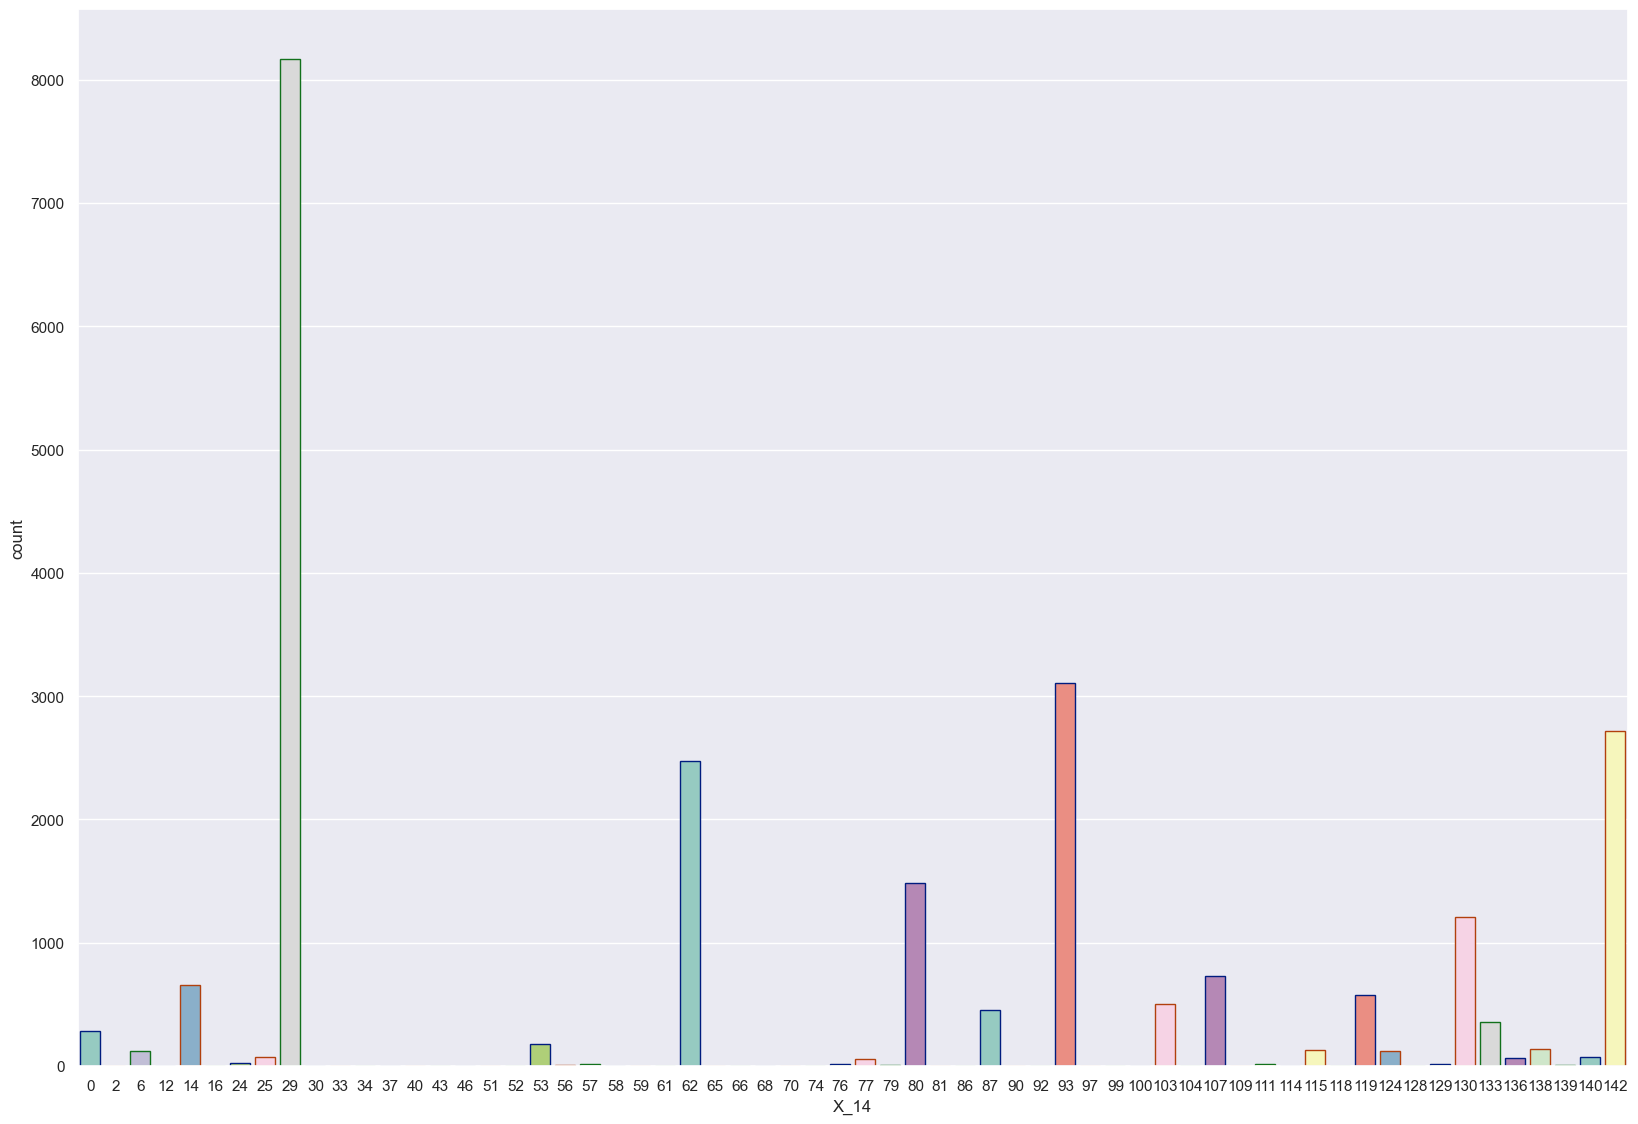

In [806]:
# Logging parameters distribution
plt.figure(figsize=(20, 14))
plt.style.use('ggplot')
sns.set(style="darkgrid")
sns.countplot(x="X_14",
              data=train_cont,
              palette="Set3",
              edgecolor=sns.color_palette("dark", 3))
plt.show()

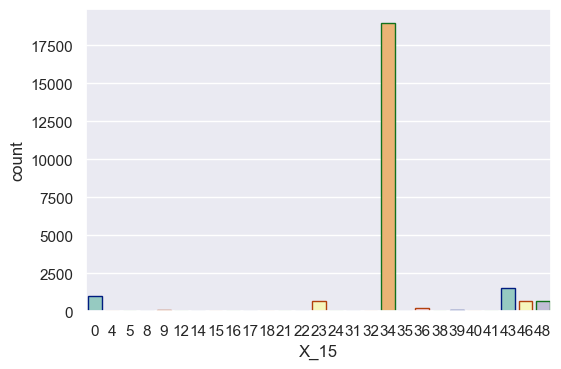

In [807]:
# Logging parameters distribution
plt.figure(figsize=(6, 4))
plt.style.use('ggplot')
sns.set(style="darkgrid")
sns.countplot(x="X_15",
              data=train_cont,
              palette="Set3",
              edgecolor=sns.color_palette("dark", 3))
plt.show()

#### Pairplot - Plot pairwise relationships in a dataset.

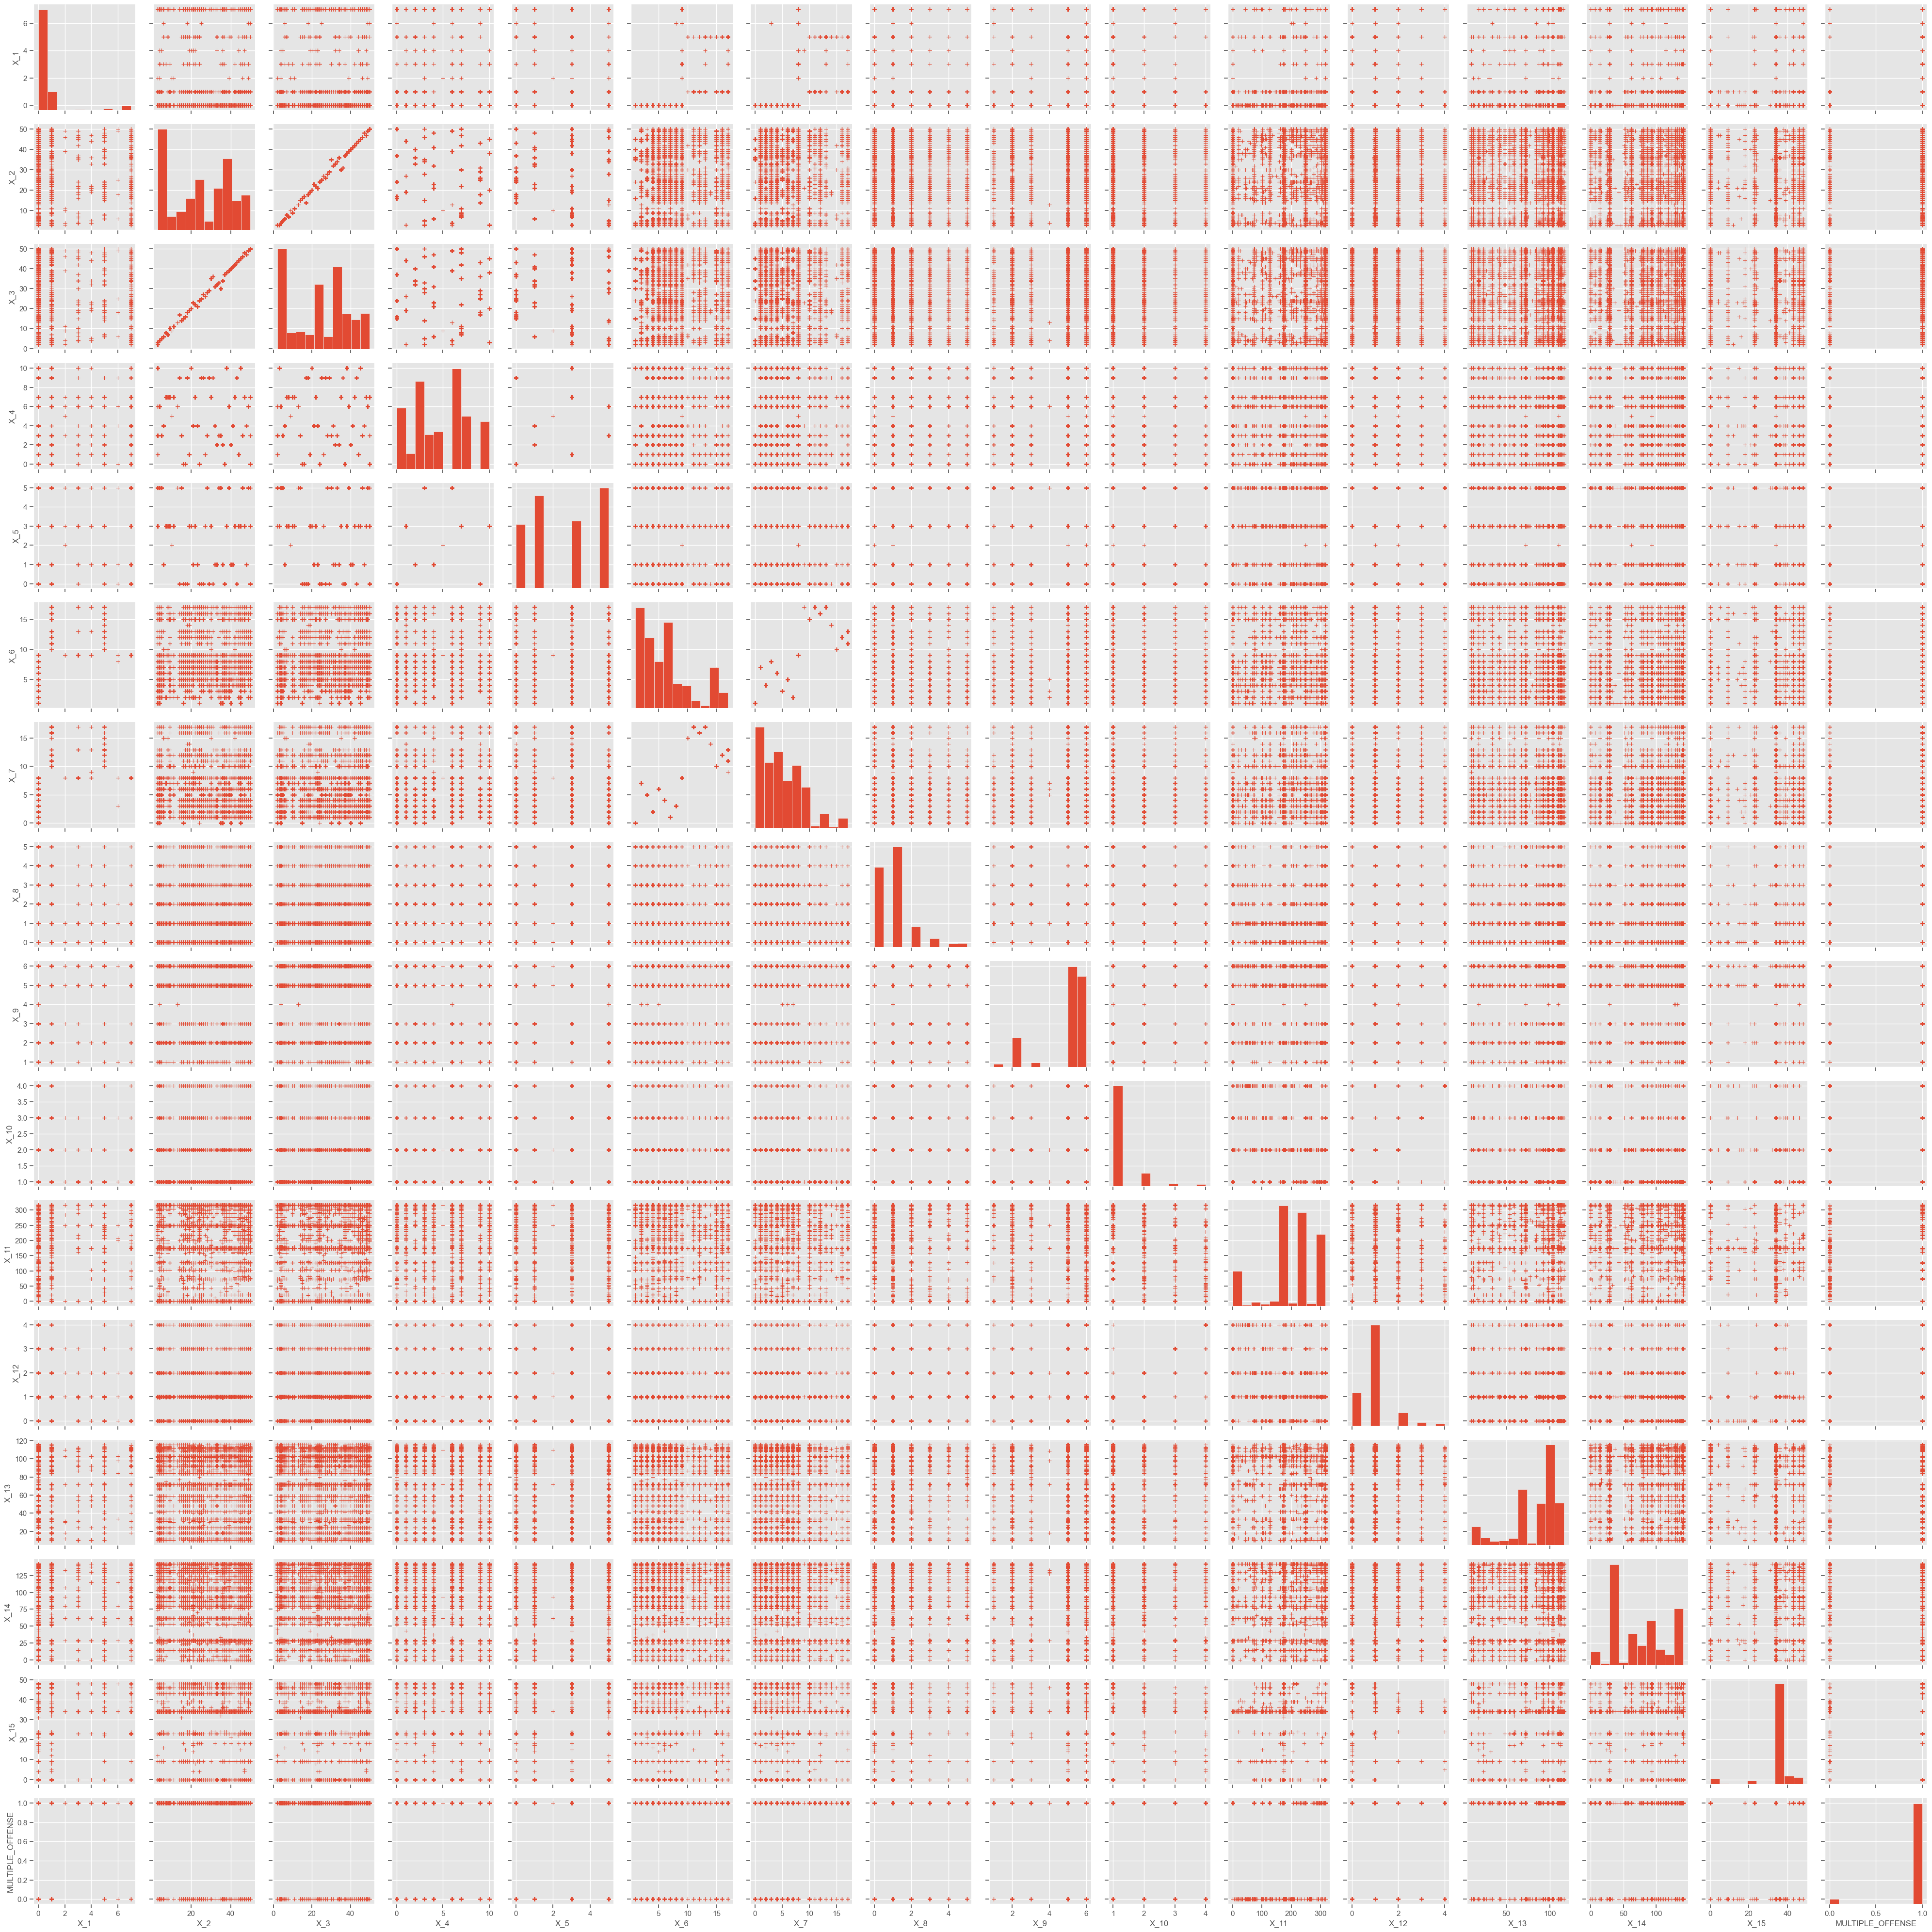

In [808]:
sns.set(style="ticks", color_codes=True)
plt.style.use('ggplot')
sns.pairplot(train_cont, palette="husl", markers="+")
plt.show()

#### Analysing the y variable. Checking if the y variable is skewed or not.


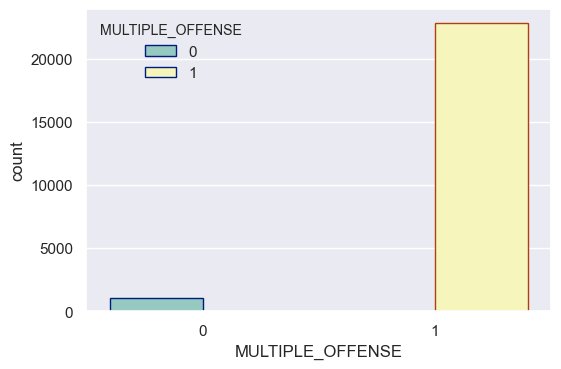

1    22788
0     1068
Name: MULTIPLE_OFFENSE, dtype: int64
1    95.523139
0     4.476861
Name: MULTIPLE_OFFENSE, dtype: float64


In [809]:
#Checking if the y variable is skewed or not

plt.style.use('ggplot')
sns.set(style="darkgrid")
sns.countplot(x='MULTIPLE_OFFENSE',
              hue='MULTIPLE_OFFENSE',
              data=train,
              palette="Set3",
              edgecolor=sns.color_palette("dark", 3))
plt.show()

print(train['MULTIPLE_OFFENSE'].value_counts())
print(train['MULTIPLE_OFFENSE'].value_counts(normalize=True) * 100)

#The y variable is skewed so we need to do sampling of the data.

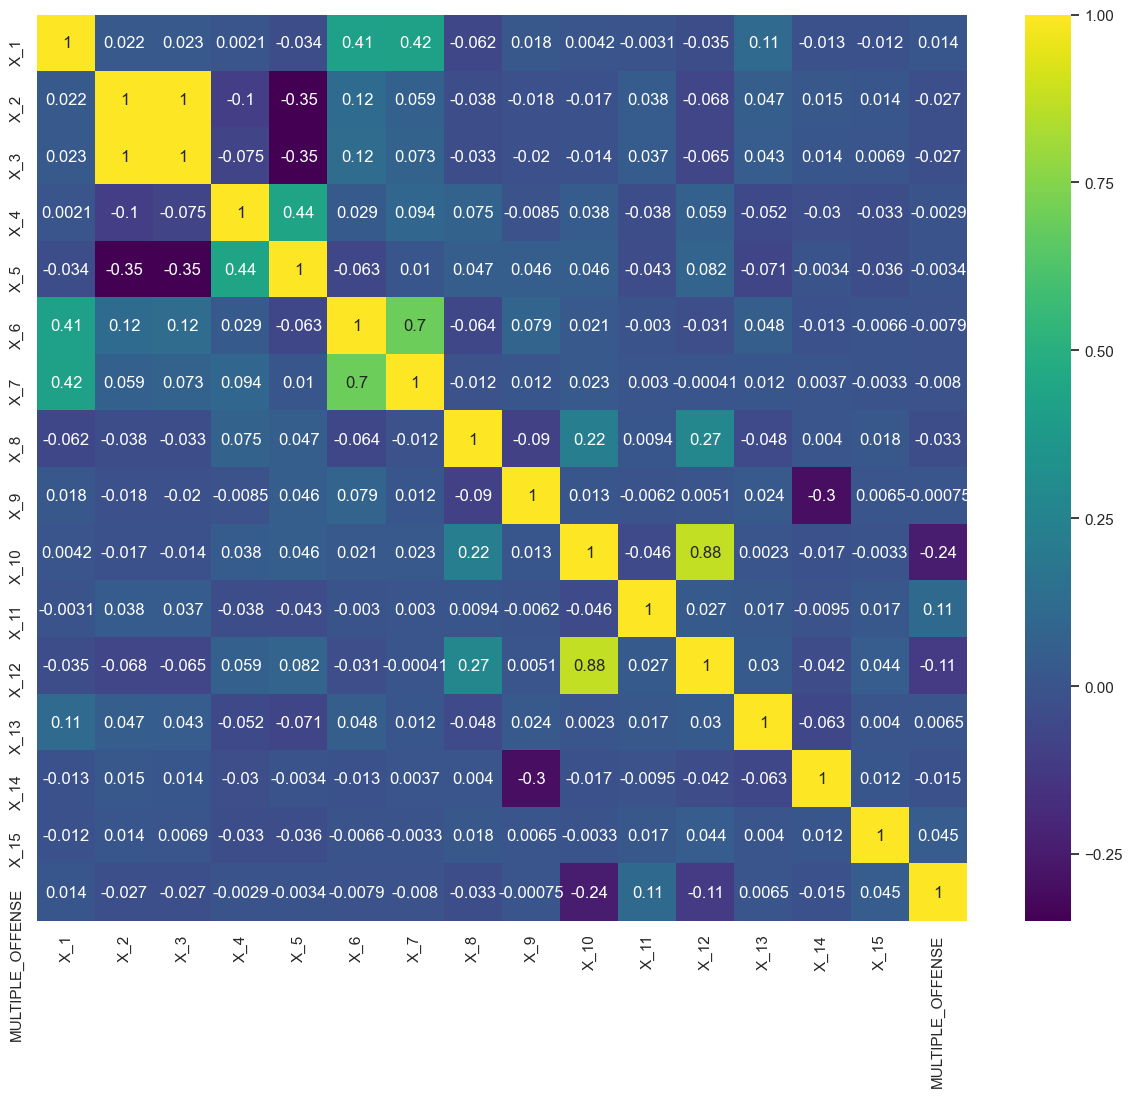

In [810]:
#Correlation check.
plt.subplots(figsize=(15, 12))
corrm = train.corr()
sns.heatmap(corrm, cmap='viridis', annot=True)

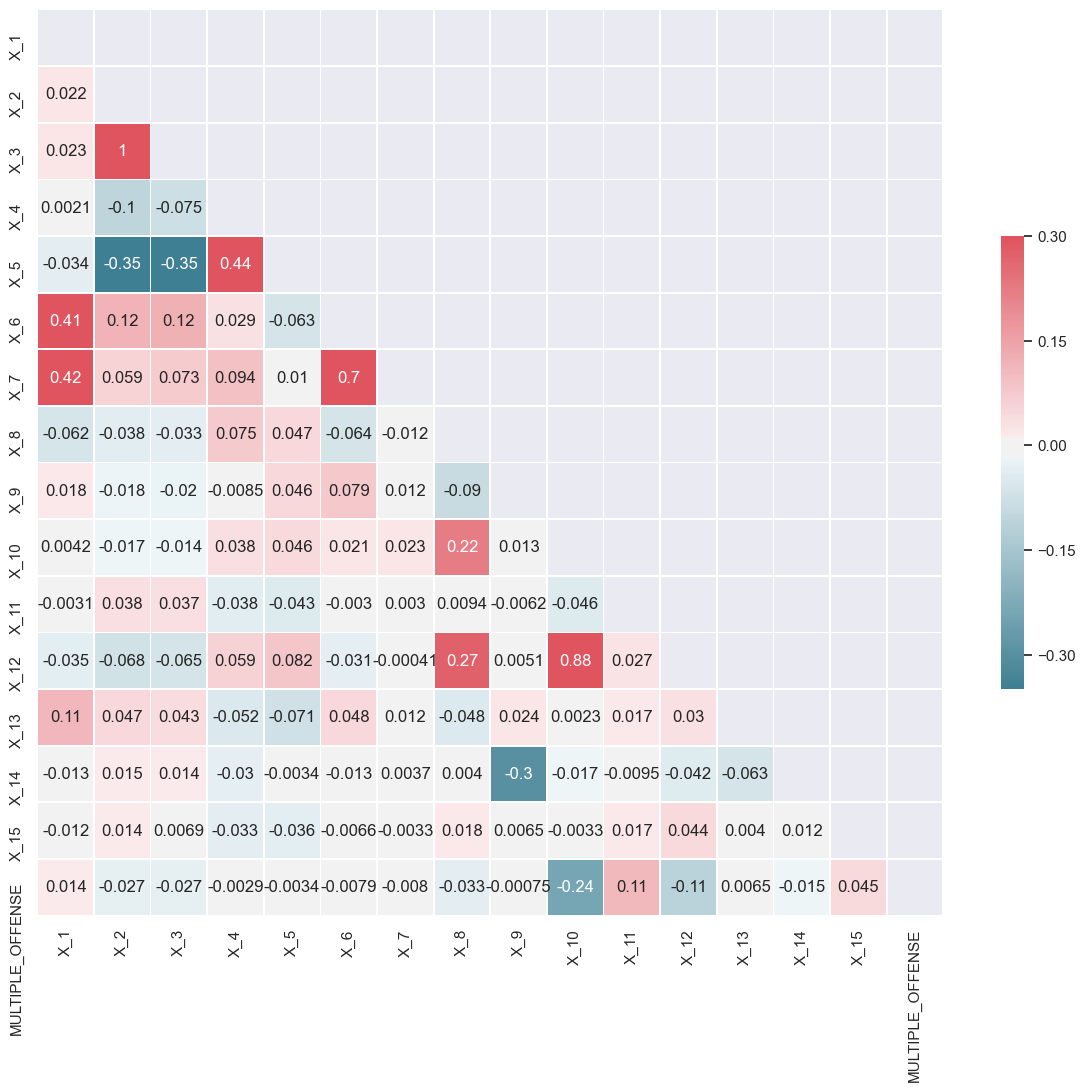

In [811]:
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(15, 12))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)
mask = np.triu(np.ones_like(corrm, dtype=np.bool))
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corrm,
            annot=True,
            mask=mask,
            cmap=cmap,
            vmax=.3,
            center=0,
            square=True,
            linewidths=.5,
            cbar_kws={"shrink": .5})

##### Saving the correlation matrix in an excel file.

In [812]:
corrm.to_excel('C:/Users/shaur/Downloads/6a62a5b4967411ea/Dataset/corr.xlsx')

### We only have 15 features in the Dataset. Therefore did not work on feature reduction.

## Final Dataset for applying ML algorithms

In [813]:
X = train_cont.iloc[:,:-1]
y = train_cont['MULTIPLE_OFFENSE']

## Building model from statsmodels

In [814]:
# method 2: divide the data into training and testing for statsmodels.formula.api
import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split
train, test = train_test_split(train_cont, test_size = 0.3, random_state = 12345)

In [815]:
# verify the no of obs in training and testing after split
print('No of obs in training: ', len(train), ' | ', 'No of obs in testing: ', len(test))

No of obs in training:  16699  |  No of obs in testing:  7157


In [816]:
features_final = X.columns
model_param_final = 'MULTIPLE_OFFENSE ~ ' + ' + '.join(features_final)

##### Bulding a Linear Regression Model for analysis

In [817]:
lr = smf.logit(formula=model_param_final, data=train).fit()

Optimization terminated successfully.
         Current function value: 0.125575
         Iterations 8


In [818]:
print(lr.summary())

                           Logit Regression Results                           
Dep. Variable:       MULTIPLE_OFFENSE   No. Observations:                16699
Model:                          Logit   Df Residuals:                    16683
Method:                           MLE   Df Model:                           15
Date:                Sat, 13 Jun 2020   Pseudo R-squ.:                  0.3092
Time:                        14:35:25   Log-Likelihood:                -2097.0
converged:                       True   LL-Null:                       -3035.7
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      5.0892      0.333     15.281      0.000       4.437       5.742
X_1            0.0887      0.041      2.187      0.029       0.009       0.168
X_2           -0.0248      0.041     -0.607      0.5

#### We are getting a poor score with Logistic Regression because the data is heavily skewed. Our accuracies will be very misleading. Also, we took all the variables in the dataset. We might have insignificant variables. Let us fix that. 

#### Let us run a kNN algorithm to see the difference between skewed and balanced data.

In [819]:
# import the packages
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.model_selection import GridSearchCV

In [820]:
#set the tuning parameters (k) for grid search
tuned_parameters = {
    'n_neighbors': [7, 9, 11, 13, 15,17,19],
   # 'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
}

# build the KNN model
knn_clf = GridSearchCV(KNeighborsClassifier(),
                       tuned_parameters,
                       cv=10,
                       verbose = 10,
                       n_jobs=-1,
                       scoring='roc_auc')

In [821]:
# model fit
knn_clf.fit(X_train, y_train)
knn_clf.best_score_

Fitting 10 folds for each of 7 candidates, totalling 70 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done  63 out of  70 | elapsed:    4.7s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:    4.9s finished


0.8792314434735488

In [822]:
metrics.roc_auc_score( y_train, knn_clf.predict_proba( X_train )[:, 1] )

0.9628956915375841

In [823]:
knn_clf.best_params_

{'n_neighbors': 19}

In [824]:
# re-building the model for the best n_neighbors
knn_clf = KNeighborsClassifier( n_neighbors = 19)
knn_clf.fit( X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=19, p=2,
                     weights='uniform')

In [825]:
# confusion matrix
knn_cm = metrics.confusion_matrix( y_test, knn_clf.predict( X_test ))

Text(0.5, 17.25, 'Predicted label')

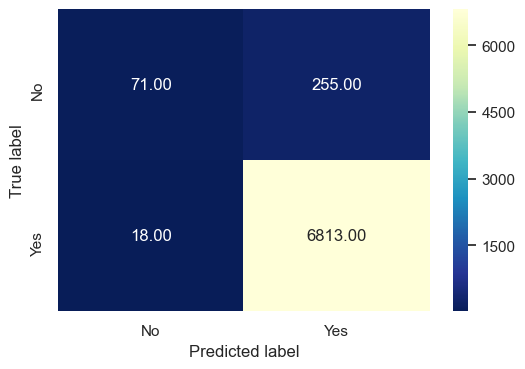

In [826]:
sns.heatmap(knn_cm, annot=True,  cmap = 'YlGnBu_r',fmt='.2f', xticklabels = ["No", "Yes"] , yticklabels = ["No", "Yes"] )
plt.ylabel('True label')
plt.xlabel('Predicted label')

In [827]:
# get the model accuracy
print(metrics.accuracy_score(y_train, knn_clf.predict(X_train)))
print(metrics.accuracy_score(y_test, knn_clf.predict(X_test)))

0.9622133061859992
0.9618555260584044


In [828]:
# get the probability score on training and testing
train_predict_prob = pd.DataFrame(knn_clf.predict_proba(X_train))[1]
test_predict_prob = pd.DataFrame(knn_clf.predict_proba(X_test))[1]

In [829]:
# get the model auc
print(metrics.roc_auc_score(y_train, train_predict_prob))
print(metrics.roc_auc_score(y_test, test_predict_prob))

0.9628956915375841
0.8806561659989242


In [830]:
# Compute precision, recall, F-measure and support
from sklearn.metrics import classification_report
print(classification_report(y_test, knn_clf.predict( X_test )))

              precision    recall  f1-score   support

           0       0.80      0.22      0.34       326
           1       0.96      1.00      0.98      6831

    accuracy                           0.96      7157
   macro avg       0.88      0.61      0.66      7157
weighted avg       0.96      0.96      0.95      7157



#### Interpretation: We can see from poor precion and recall for '1's in classification report and AUC that model performacne is not upto the mark. High accuracy score is misleading because of skewed data.

We will now rebuild the model after re-balancing the data


#### We will now rebuild the model after re-balancing the data.

Oversampling & Undersampling for imbalance data


In [831]:
# import the packages
import imblearn
from imblearn.under_sampling import RandomUnderSampler 
from imblearn.over_sampling import RandomOverSampler 
from imblearn.over_sampling import SMOTE
from collections import Counter

#### Rebuild model after undersampling

In [832]:
# perform the under sampling
rus = RandomUnderSampler(random_state = 500)
X_res_train, y_res_train = rus.fit_sample(X_train, y_train)
print('Original dataset shape {}'.format(Counter(y_train)))
print('Oversampled dataset shape {}'.format(Counter(y_res_train)))

Original dataset shape Counter({1: 15957, 0: 742})
Oversampled dataset shape Counter({0: 742, 1: 742})


In [833]:
# rebuild the model after resampling
knn_clf = KNeighborsClassifier( n_neighbors = 19 )

In [834]:
# Refitting the model on under sampled data
knn_clf.fit(X_res_train, y_res_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=19, p=2,
                     weights='uniform')

In [835]:
# get the model accuracy
print(metrics.accuracy_score(y_res_train, knn_clf.predict(X_res_train)))
print(metrics.accuracy_score(y_test, knn_clf.predict(X_test)))

0.7904312668463612
0.7654044990917982


In [836]:
# get the probability score on training and testing
train_predict_prob = pd.DataFrame(knn_clf.predict_proba(X_res_train))[1]
test_predict_prob = pd.DataFrame(knn_clf.predict_proba(X_test))[1]

In [837]:
# get the model auc
print(metrics.roc_auc_score(y_res_train, train_predict_prob))
print(metrics.roc_auc_score(y_test, test_predict_prob))

0.8838972399212444
0.83999549150256


#### Refit model after oversampling

In [838]:
# perform the over sampling
ros = RandomOverSampler(random_state = 500)
X_res_train, y_res_train = ros.fit_sample(X_train, y_train)
print('Original dataset shape {}'.format(Counter(y_train)))
print('Oversampled dataset shape {}'.format(Counter(y_res_train)))

Original dataset shape Counter({1: 15957, 0: 742})
Oversampled dataset shape Counter({0: 15957, 1: 15957})


In [839]:
# rebuild the model after resampling
knn_clf = KNeighborsClassifier( n_neighbors = 19 )

In [840]:
# Refitting the model on over sampled data
knn_clf.fit(X_res_train, y_res_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=19, p=2,
                     weights='uniform')

In [841]:
# get the model accuracy
print(metrics.accuracy_score(y_res_train, knn_clf.predict(X_res_train)))
print(metrics.accuracy_score(y_test, knn_clf.predict(X_test)))

0.9549414050260074
0.9002375296912114


In [842]:
# get the probability score on training and testing
train_predict_prob = pd.DataFrame(knn_clf.predict_proba(X_res_train))[1]
test_predict_prob = pd.DataFrame(knn_clf.predict_proba(X_test))[1]

In [843]:
# get the model auc
print(metrics.roc_auc_score(y_res_train, train_predict_prob))
print(metrics.roc_auc_score(y_test, test_predict_prob))

0.9985398575931699
0.8994005584429697


#### We will use the oversampled data now for our predictions with a better performing model.

In [844]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

rand = RandomForestClassifier(random_state= 42).fit(X_res_train,y_res_train)

In [845]:
rand.score(X_res_train,y_res_train)

1.0

In [846]:
rand.predict(X_test)

array([1, 1, 1, ..., 1, 1, 1], dtype=int64)

In [847]:
y_pred1 = pd.DataFrame( { 'actual':  y_test,
                                'predicted': rand.predict( X_test) } )

In [848]:
y_pred1

,actual,predicted
11057,1,1
21447,1,1
19198,1,1
18539,1,1
21149,1,1
...,...,...
13044,0,0
6392,1,1
8940,1,1
9284,1,1


In [849]:
print(metrics.accuracy_score(y_pred1.actual, y_pred1.predicted))
print(metrics.roc_auc_score(y_pred1.actual, y_pred1.predicted))

0.9902193656560011
0.9291517019577836


Text(0.5, 17.25, 'Predicted label')

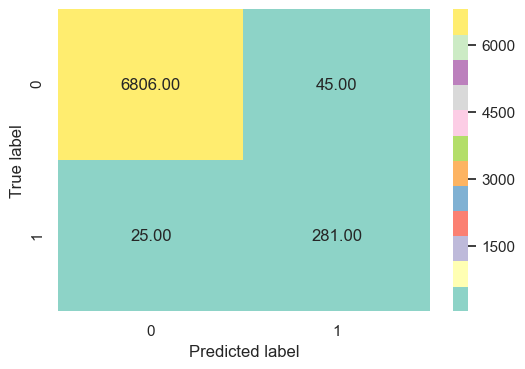

In [850]:
rftree_cm = metrics.confusion_matrix(y_pred1.predicted, y_pred1.actual, [1, 0])
sns.heatmap(rftree_cm,
            annot=True,
            cmap='Set3',
            fmt='.2f',
            )

plt.ylabel('True label')
plt.xlabel('Predicted label')

In [851]:
from sklearn.metrics import recall_score

recall_score(y_test,  rand.predict( X_test))

0.996340213731518

#### Hypertuning Random Forest to improve the model further

In [747]:
rfc = RandomForestClassifier(n_jobs=-1,
                             n_estimators=50,
                             oob_score=False,
                             random_state=42)

param_grid = {
    'n_estimators': np.arange(100, 500, 50),
    'max_features': ['auto', 'log2'],
    'max_depth': [15, 25, 30],
    'min_samples_split': [2, 3, 4],
    'min_samples_leaf': [2, 3, 4]
}

CV_rfc = GridSearchCV(estimator=rfc,
                      param_grid=param_grid,
                      cv=5,
                      verbose=10,
                      n_jobs=-1)
CV_rfc.fit(X_res_train, y_res_train)
print(CV_rfc.best_params_)

Fitting 5 folds for each of 432 candidates, totalling 2160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   10.3s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   18.2s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   25.7s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   29.3s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   36.3s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:   43.9s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:   54.3s
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 165 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  2

{'max_depth': 30, 'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}


In [748]:
CV_rfc.best_params_

{'max_depth': 30,
 'max_features': 'auto',
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 200}

In [749]:
CV_rfc.best_score_

0.9971172791170609

In [750]:
CV_rfc.predict(X_test)

array([1, 1, 1, ..., 1, 1, 1], dtype=int64)

In [751]:
y_pred2 = pd.DataFrame( { 'actual':  y_test,
                                'predicted': CV_rfc.predict( X_test) } )

In [752]:
y_pred2

,actual,predicted
11057,1,1
21447,1,1
19198,1,1
18539,1,1
21149,1,1
...,...,...
13044,0,0
6392,1,1
8940,1,1
9284,1,1


In [753]:
print(metrics.accuracy_score(y_pred2.actual, y_pred2.predicted))
print(metrics.roc_auc_score(y_pred2.actual, y_pred2.predicted))

0.9906385356993154
0.9629638610700226


Text(0.5, 17.25, 'Predicted label')

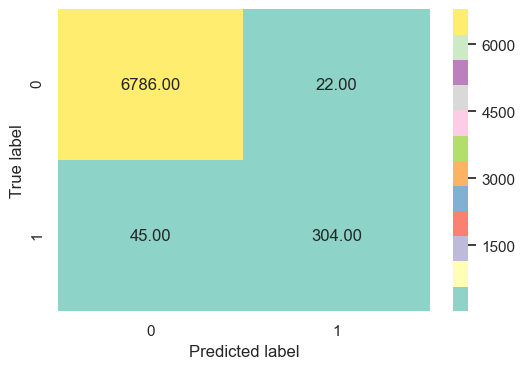

In [754]:
rftree_cm = metrics.confusion_matrix(y_pred2.predicted, y_pred2.actual, [1, 0])
sns.heatmap(rftree_cm,
            annot=True,
            cmap='Set3',
            fmt='.2f',
            )

plt.ylabel('True label')
plt.xlabel('Predicted label')

In [755]:
from sklearn.metrics import recall_score

recall_score(y_pred2.actual, y_pred2.predicted)

0.9934123847167325

In [756]:
# Compute precision, recall, F-measure and support
from sklearn.metrics import classification_report
print(classification_report(y_test, CV_rfc.predict( X_test)))

              precision    recall  f1-score   support

           0       0.87      0.93      0.90       326
           1       1.00      0.99      1.00      6831

    accuracy                           0.99      7157
   macro avg       0.93      0.96      0.95      7157
weighted avg       0.99      0.99      0.99      7157



#### Gradient Boosting

In [879]:
import lightgbm as lgb
fit_params = {
    "early_stopping_rounds": 30,
    "eval_metric": 'auc',
    "eval_set": [(X_test, y_test)],
    'eval_names': ['valid'],
    #'callbacks': [lgb.reset_parameter(learning_rate=learning_rate_010_decay_power_099)],
    'verbose': 100,
    'categorical_feature': 'auto'
}

from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform
param_test = {
    'num_leaves': sp_randint(6, 50),
    'min_child_samples': sp_randint(100, 500),
    'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
    'subsample': sp_uniform(loc=0.2, scale=0.8),
    'colsample_bytree': sp_uniform(loc=0.4, scale=0.6),
    'reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50, 100],
    'reg_lambda': [0, 1e-1, 1, 5, 10, 20, 50, 100]
}

n_HP_points_to_test = 100

import lightgbm as lgb
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

#n_estimators is set to a "large value". The actual number of trees build will depend on early stopping and 5000 define only the absolute maximum
clf = lgb.LGBMClassifier(max_depth=-1,
                         random_state=42,
                         silent=True,
                         metric='None',
                         n_jobs=-1,
                         n_estimators=5000)
gs = RandomizedSearchCV(estimator=clf,
                        param_distributions=param_test,
                        n_iter=n_HP_points_to_test,
                        scoring='roc_auc',
                        cv=5,
                        refit=True,
                        random_state=42,
                        verbose=10,
                        n_jobs=-1)

gs.fit(X_res_train, y_res_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   17.0s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   24.4s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   34.7s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   58.7s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 165 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  4

RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=LGBMClassifier(boosting_type='gbdt',
                                            class_weight=None,
                                            colsample_bytree=1.0,
                                            importance_type='split',
                                            learning_rate=0.1, max_depth=-1,
                                            metric='None', min_child_samples=20,
                                            min_child_weight=0.001,
                                            min_split_gain=0.0,
                                            n_estimators=5000, n_jobs=-1,
                                            num_leaves=31, objective=None,
                                            random_state=42, reg_alpha=0.0,
                                            reg_la...
                                        'num_leaves': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000023753E875

In [880]:
#from sklearn.ensemble import GradientBoostingClassifier
#import xgboost as xgb
#
#pargrid_grad = {
#    'n_estimators': np.arange(100, 500, 50),
#    'max_depth': [15, 25, 30],
#    'min_samples_split': [2, 3, 4],
#    'min_samples_leaf': [2, 3, 4],
#    'learning_rate': [10**x for x in range(-3, 1)]
#}
#
#gscv_grad = GridSearchCV(estimator=xgb(random_state=42),
#                         param_grid=pargrid_grad,
#                         cv=5,
#                         verbose=10,
#                         n_jobs=-1)
#
#gscv_grad.fit(X_res_train, y_res_train)

In [895]:
print(gs.best_params_)

{'colsample_bytree': 0.48885215797203996, 'min_child_samples': 180, 'min_child_weight': 1e-05, 'num_leaves': 7, 'reg_alpha': 0.1, 'reg_lambda': 5, 'subsample': 0.2411830009999915}


In [896]:
gs.best_score_

1.0

In [897]:
gs.predict(X_test)

array([1, 1, 1, ..., 1, 1, 1], dtype=int64)

In [898]:
y_pred3 = pd.DataFrame( { 'actual':  y_test,
                                'predicted': gs.predict( X_test) } )

In [899]:
print(metrics.accuracy_score(y_pred3.actual, y_pred3.predicted))
print(metrics.roc_auc_score(y_pred3.actual, y_pred3.predicted))

0.9995808299566857
0.9983198662179723


Text(0.5, 17.25, 'Predicted label')

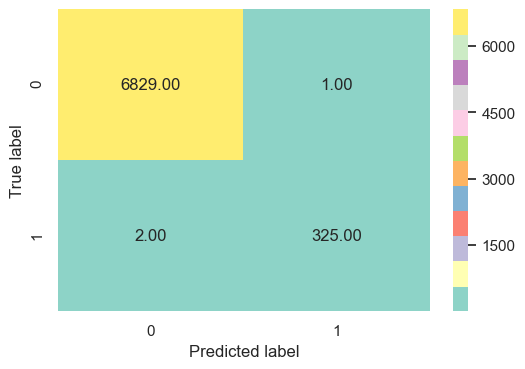

In [900]:
rftree_cm = metrics.confusion_matrix(y_pred3.predicted, y_pred3.actual, [1, 0])
sns.heatmap(rftree_cm,
            annot=True,
            cmap='Set3',
            fmt='.2f',
            )

plt.ylabel('True label')
plt.xlabel('Predicted label')

In [901]:
from sklearn.metrics import recall_score

recall_score(y_pred3.actual, y_pred3.predicted)

0.9997072170985214

In [902]:
# Compute precision, recall, F-measure and support
from sklearn.metrics import classification_report
print(classification_report(y_test, gs.predict( X_test)))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       326
           1       1.00      1.00      1.00      6831

    accuracy                           1.00      7157
   macro avg       1.00      1.00      1.00      7157
weighted avg       1.00      1.00      1.00      7157



## Predictions on the test data

In [889]:
test_cont

,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,X_9,X_10,X_11,X_12,X_13,X_14,X_15
0,0,30,35,7,3,6,4,0,5,1,174,0.972236,72,119,23
1,0,44,44,1,3,7,1,4,6,1,316,0.000000,12,29,34
2,0,34,33,3,5,2,7,3,1,1,316,1.000000,72,0,34
3,7,3,2,3,5,9,8,0,5,1,174,1.000000,112,87,34
4,0,7,8,7,3,2,7,1,5,1,174,0.000000,112,93,43
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15898,1,22,22,7,3,15,10,0,5,1,174,0.000000,72,29,43
15899,0,35,30,3,5,1,0,2,3,2,0,2.000000,72,93,34
15900,0,26,27,9,0,6,4,2,6,1,0,1.000000,72,62,34
15901,0,21,23,4,1,2,7,1,6,2,249,2.000000,92,62,34


In [890]:
test_cont['MULTIPLE_OFFENSE']= gs.predict(test_cont)

In [891]:
test_cont['MULTIPLE_OFFENSE'].value_counts()

1    15177
0      726
Name: MULTIPLE_OFFENSE, dtype: int64

In [892]:
sample_submission = pd.concat([test_cat['INCIDENT_ID'], test_cont['MULTIPLE_OFFENSE']], axis = 1)

In [903]:
sample_submission.to_csv('C:/Users/shaur/Downloads/6a62a5b4967411ea/Dataset/sample_submission.csv', index = False )

In [894]:
# Compute precision, recall, F-measure and support
from sklearn.metrics import classification_report
print(classification_report(y_test, gs.predict( X_test)))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       326
           1       1.00      1.00      1.00      6831

    accuracy                           1.00      7157
   macro avg       1.00      1.00      1.00      7157
weighted avg       1.00      1.00      1.00      7157



#### Recall score of 0.99 along with the sample submission file uploaded.

In [868]:
#test_cont.drop(columns= ['MULTIPLE_OFFENSE'], inplace= True)

In [906]:
test_cont['MULTIPLE_OFFENSE'].value_counts(normalize=True)

1    0.954348
0    0.045652
Name: MULTIPLE_OFFENSE, dtype: float64